# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [74]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Delta-3",
    "conditions" : [
        "Delta-3", "Delta-4",
        "Omicron_BA.1-2", "Omicron_BA.1-3", #,
        "Omicron_BA.2-1", "Omicron_BA.2-2"
    ]
}

In [75]:
# uncomment to reset or if first time running notebook
# datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [76]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3
12,2022-10-22_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1,Lib-1_2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2
14,2022-10-22_thaw-2_VSVG_control_1,Lib-1,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1,Lib-1_2022-10-22_thaw-2_no-antibody_control_1,Lib-1_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1
15,2022-10-22_thaw-2_VSVG_control_1,Lib-2,thaw-2,2,2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1,Lib-2_2022-10-22_thaw-2_no-antibody_control_1,Lib-2_2022-10-22_thaw-2_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2


In [77]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATTAGAAAACAACCT,-0.8331,0.0015,9697,1688,1154203,358015,0.5,2,K276R L1198F,2,K278R L1200F,20,Delta,1,Delta-3
1,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACCGTCACCACCAG,0.1042,0.0010,8201,2734,1154203,358015,0.5,3,T22I R401K E1090D,3,T22I R403K E1092D,20,Delta,1,Delta-3
2,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ACCAAAAGTAGATTCA,0.1985,0.0010,8084,2877,1154203,358015,0.5,2,A1068T,1,A1070T,20,Delta,1,Delta-3
3,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ATCCCACGACATAAAA,-0.3469,0.0015,7226,1762,1154203,358015,0.5,1,D142N,1,D142N,20,Delta,1,Delta-3
4,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GACTAATGACGGGTTC,-0.3512,0.0015,7112,1729,1154203,358015,0.5,0,NaN,0,NaN,20,Delta,1,Delta-3


**Optionally subset the variants**

In [78]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [79]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/772968 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [80]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 745148 variants, 77120 had fewer than 100 counts before selection, and were filtered out


In [81]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATTAGAAAACAACCT,-0.8331,0.0015,9697,1688,1154203,358015,0.5,2,K276R L1198F,2,K278R L1200F,20,Delta,1,Delta-3
1,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACCGTCACCACCAG,0.1042,0.0010,8201,2734,1154203,358015,0.5,3,T22I R401K E1090D,3,T22I R403K E1092D,20,Delta,1,Delta-3
2,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ACCAAAAGTAGATTCA,0.1985,0.0010,8084,2877,1154203,358015,0.5,2,A1068T,1,A1070T,20,Delta,1,Delta-3
3,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ATCCCACGACATAAAA,-0.3469,0.0015,7226,1762,1154203,358015,0.5,1,D142N,1,D142N,20,Delta,1,Delta-3
4,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GACTAATGACGGGTTC,-0.3512,0.0015,7112,1729,1154203,358015,0.5,0,NaN,0,,20,Delta,1,Delta-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759769,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TGGACGAGAAATCCAG,-0.1622,0.0356,100,139,6478978,10063399,0.5,1,E468Q,1,E471Q,56,Omicron_BA.2,2,Omicron_BA.2-2
759770,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTACACAAAACGTGTG,0.5809,0.0296,100,233,6478978,10063399,0.5,1,K1188S,1,K1191S,56,Omicron_BA.2,2,Omicron_BA.2-2
759771,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCATAAAAATTTCAA,1.5701,0.0252,100,463,6478978,10063399,0.5,1,L10I,1,L10I,56,Omicron_BA.2,2,Omicron_BA.2-2
759772,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCCCTGCAATAATTC,1.3412,0.0260,100,395,6478978,10063399,0.5,3,G72C L365I A1219S,3,G75C L368I A1222S,56,Omicron_BA.2,2,Omicron_BA.2-2


**Optionally, scale the counts**

In [82]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [83]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [84]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [85]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [86]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [87]:
# func_score_df.to_csv("Delta_BA1_BA2_func_score_df.csv")

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [17]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [88]:
# tqdm.pandas()
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition']
)

  0%|          | 0/65282 [00:00<?, ?it/s]

  0%|          | 0/57566 [00:00<?, ?it/s]

  0%|          | 0/54291 [00:00<?, ?it/s]

  0%|          | 0/52081 [00:00<?, ?it/s]

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [89]:
# datasets = pd.DataFrame()

In [90]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,"[Delta-3, Omicron_BA.1-2]",<multidms.data.MultiDmsData object at 0x7f1045...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f0e30...


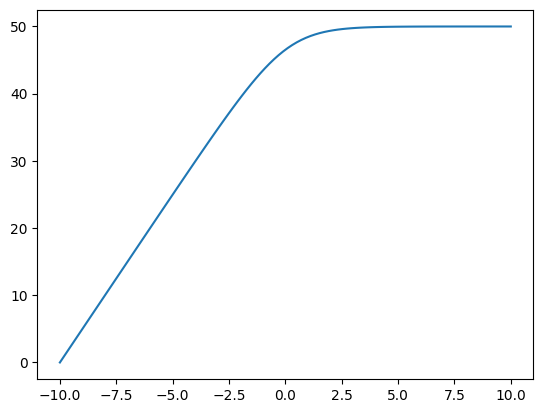

In [91]:
import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [92]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,"[Delta-3, Omicron_BA.1-2]",<multidms.data.MultiDmsData object at 0x7f1045...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Delta-3,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f0e30...


## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [69]:
# un-comment to re-initialize results
# models = defaultdict(list)

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [97]:
import multidms.model as model
for dataset in [1]:
    for ge_func in [model.sigmoidal_global_epistasis, model.perceptron_global_epistasis]:
        for output_act in [model.identity_activation, model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=100
            )
            
            start = time.time()
            imodel.fit(lasso_shift=1e-5, maxiter=5000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
#             models["ge_func"].append(ge_func)
#             models["output_act"].append(output_act)
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 199 seconds
done. fitting time = 200 seconds
done. fitting time = 220 seconds
done. fitting time = 220 seconds


,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f0d...,0
1,<multidms.model.MultiDmsModel object at 0x7f10...,0
2,<multidms.model.MultiDmsModel object at 0x7f0d...,0
3,<multidms.model.MultiDmsModel object at 0x7f0d...,0
4,<multidms.model.MultiDmsModel object at 0x7f0d...,1
5,<multidms.model.MultiDmsModel object at 0x7f0e...,1
6,<multidms.model.MultiDmsModel object at 0x7efa...,1
7,<multidms.model.MultiDmsModel object at 0x7efa...,1
8,<multidms.model.MultiDmsModel object at 0x7efa...,1
9,<multidms.model.MultiDmsModel object at 0x7f0e...,1


In [ ]:
for m in [8,9,10,11]:
    
    model = models_df.loc[m, "model"]
    
    fig, ax = plt.subplots(1, 2, figsize=[8,4])
    model.plot_epistasis(ax=ax[0], alpha=0.15, show=False)
    model.plot_pred_accuracy(ax=ax[1], alpha=0.15, show=False, legend=False)
    
    plt.show()   
    
    fig, ax = plt.subplots(1,2, figsize=[10, 5])
    shifts = [p for p in model.params.keys() if p.startswith("S")]
    # shifts
    model.plot_param_hist('S_Omicron_BA.1-2', ax=ax[0], show=False)
    model.plot_param_hist('β', ax=ax[1], show=False)
    plt.show()

In [103]:
for m in [8, 9, 10, 11]:
    
    model = models_df.loc[m, "model"]
    chart = model.mut_shift_plot()
    chart.save(f"model-fit-{m}.html")

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [56]:
model.params['α']

{'p_biases': DeviceArray([-0.83786461,  1.55572419,  0.14314948, -1.38693121,
               0.93936036], dtype=float64),
 'p_weights_1': DeviceArray([1.06963075, 0.        , 0.24082365, 0.        , 0.27765072],            dtype=float64),
 'p_weights_2': DeviceArray([0.        , 0.72272396, 0.        , 1.63609773, 0.        ],            dtype=float64)}

In [ ]:
imodel = models_df.loc[8, "model"]
chart = imodel.mut_shift_plot()
chart.save("model")

**models with the same dataset share the reference. This saves precious memory.**

In [47]:
model_w_same_dataset = models_df.loc[1, "model"]
model_w_same_dataset.data is a_model_object.data

True

**The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.**

In [48]:
a_model_object.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Delta-4,times_seen_Omicron_BA.1-2,times_seen_Omicron_BA.1-3,times_seen_Omicron_BA.2-1,times_seen_Omicron_BA.2-2,...,S_Delta-4,F_Delta-4,S_Omicron_BA.1-2,F_Omicron_BA.1-2,S_Omicron_BA.1-3,F_Omicron_BA.1-3,S_Omicron_BA.2-1,F_Omicron_BA.2-1,S_Omicron_BA.2-2,F_Omicron_BA.2-2
0,M1F,M,1,F,9.0,3.0,0.0,0.0,0.0,0.0,...,2.120120,-0.182831,0.000000,-1.966375,0.000000,-1.966374,0.000000,-1.966375,0.000000,-1.966375
1,M1I,M,1,I,8.0,11.0,5.0,6.0,6.0,10.0,...,-0.966780,-2.474190,0.015337,-2.466338,-0.010819,-2.466621,-0.002576,-2.466681,-0.018790,-2.466871
2,M1K,M,1,K,5.0,7.0,0.0,0.0,0.0,0.0,...,-1.415097,-2.437194,0.000000,-2.312317,0.000000,-2.312310,0.000000,-2.312344,0.000000,-2.312343
3,M1L,M,1,L,3.0,9.0,0.0,0.0,0.0,1.0,...,-0.245569,-2.124040,0.000000,-2.035302,0.000000,-2.035301,0.000000,-2.035303,0.007721,-2.032217
4,M1N,M,1,N,4.0,1.0,0.0,0.0,0.0,0.0,...,-1.972156,-1.041151,0.000000,0.925342,0.000000,0.925342,0.000000,0.925342,0.000000,0.925342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10737,S1252T,S,1252,T,32.0,24.0,114.0,94.0,94.0,88.0,...,-0.119065,-0.274916,0.096206,-0.040839,0.099567,-0.037216,-0.006091,-0.151676,0.056603,-0.083624
10738,S1252V,S,1252,V,16.0,14.0,80.0,61.0,68.0,65.0,...,0.065014,0.067842,0.523104,0.529165,0.674519,0.666965,0.314978,0.326793,0.271694,0.283049
10739,S1252W,S,1252,W,5.0,7.0,24.0,29.0,28.0,30.0,...,0.760367,1.137006,-0.154376,0.394640,0.062248,0.600047,-0.162072,0.387055,0.027540,0.568243
10740,S1252Y,S,1252,Y,29.0,33.0,95.0,88.0,126.0,157.0,...,-0.036301,0.646785,0.095224,0.760502,0.433363,1.020344,0.005730,0.683865,0.010926,0.688402


In [49]:
a_model_object.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-3,,4754,-0.064501,,0.378108,0.114715,-0.064501
1,Delta-3,A1015D,2,-2.240050,A1015D,-4.167399,-2.412165,-2.240050
2,Delta-3,A1015S,2,-0.992054,A1015S,0.116610,-0.166299,-0.992054
3,Delta-3,A1015T G1204D K1245Y,2,-0.588099,A1015T G1204D K1245Y,-0.084773,-0.386139,-0.588099
4,Delta-3,A1016D,2,-0.926008,A1016D,-1.388721,-1.606429,-0.926008
...,...,...,...,...,...,...,...,...
301103,Omicron_BA.2-2,Y91T K129N,2,-2.563910,N440K N950D R681H K417N S375F R452L Q498R H655...,-5.039798,-2.450723,-2.520879
301104,Omicron_BA.2-2,Y91T T553I,2,-3.231189,N440K N950D R681H K417N S375F R452L Q498R H655...,-5.066868,-2.451469,-3.188158
301105,Omicron_BA.2-2,Y91V A1078S,2,-2.211325,A1078S N440K N950D R681H K417N S375F R452L Q49...,-3.600813,-2.362691,-2.168294
301106,Omicron_BA.2-2,Y91V S112N M177K L335P N405A C671R K679R T859A...,1,-2.630945,N440K N950D R681H K417N M177K T859A S375F R452...,-10.245995,-2.478684,-2.587914


### Visualization

In [54]:
chart = a_model_object.mut_shift_plot()

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [55]:
# chart.save("scaled-delta-3.html")

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [50]:
colors = list(sns.color_palette("colorblind", 6))
conditions = sorted(datasets.loc[0, "data"].conditions)
cc = {con:tuple(col) for con, col in zip(conditions, colors)}
for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [51]:
print(sorted(datasets.loc[0, "data"].conditions))

['Delta-3', 'Delta-4', 'Omicron_BA.1-2', 'Omicron_BA.1-3', 'Omicron_BA.2-1', 'Omicron_BA.2-2']


In [60]:
# plt.rcParams.update({'font.size': 13})
# fig = plt.figure(constrained_layout=True, figsize=(8,10))
# axd = fig.subplot_mosaic(
#     """
#     abc
#     def
#     ggg
#     ggg
#     """,
#     empty_sentinel="X",
#     sharex=True,
#     sharey=True,
# )

# model_ax_dict = {
#     "a" : 9,
#     "b" : 12,
#     "d" : 15,
#     "e" : 18,
#     "f" : 21,
#     "g" : 0
# }

# for axi, model in model_ax_dict.items():
#     moi = models_df.loc[model, "model"]
#     moi.plot_epistasis(show=False, legend=False, alpha=0.10, ax=axd[axi])
#     axd[axi].set_title(f"ref: {moi.data.reference}")
# axd["a"].set_ylabel("")
# axd["g"].set_ylabel("")
# axd["c"].axis('off')
# legend_elements = [
#     patches.Patch(
#          facecolor=col, 
#          edgecolor="black", 
#          label=con
#     )
#     for con, col in cc.items()
# ]
# axd["c"].legend(
#         handles=legend_elements, 
#         loc="center",
#         frameon=False
# )
# plt.tight_layout()
# fig.savefig("model-mixing-delta.png")
# plt.show()

In [61]:
# plt.rcParams.update({'font.size': 14})
# fig = plt.figure(constrained_layout=True, figsize=(14,8))
# axd = fig.subplot_mosaic(
#     """
#     abcg
#     defX
#     """,
#     empty_sentinel="X",
# #     sharex=True,
# #     sharey=True,
#     width_ratios=[2, 2, 2, 1],
# )

# # which fits go where
# model_ax_dict = {
#     "a" : 0,
#     "b" : 3,
#     "c" : 6,
#     "d" : 0,
#     "e" : 3,
#     "f" : 6
# }

# for axi, model in model_ax_dict.items():
#     moi = models_df.loc[model, "model"]
#     if axi in ["a", "b", "c"]:
#         moi.plot_epistasis(show=False, legend=False, alpha=0.15, ax=axd[axi])
#         axd[axi].set_title(f"ref: {moi.data.reference}")
#     else:
#         moi.plot_pred_accuracy(show=False, legend=False, alpha=0.15, ax=axd[axi])


# axd["b"].set_ylabel("")
# axd["e"].set_ylabel("")
# axd["c"].set_ylabel("")
# axd["f"].set_ylabel("")

# axd["a"].set_xlabel("")
# axd["d"].set_xlabel("")
# axd["c"].set_xlabel("")
# axd["f"].set_xlabel("")

# axd["g"].axis('off')
# legend_elements = [
#     patches.Patch(
#          facecolor=col, 
#          edgecolor="black", 
#          label=con
#     )
#     for con, col in cc.items()
# ]
# axd["g"].legend(
#         handles=legend_elements, 
#         loc="center",
#         frameon=False
# )
# plt.tight_layout()
# fig.savefig("ref-comparison-scatter-epi-acc.png")
# plt.show()

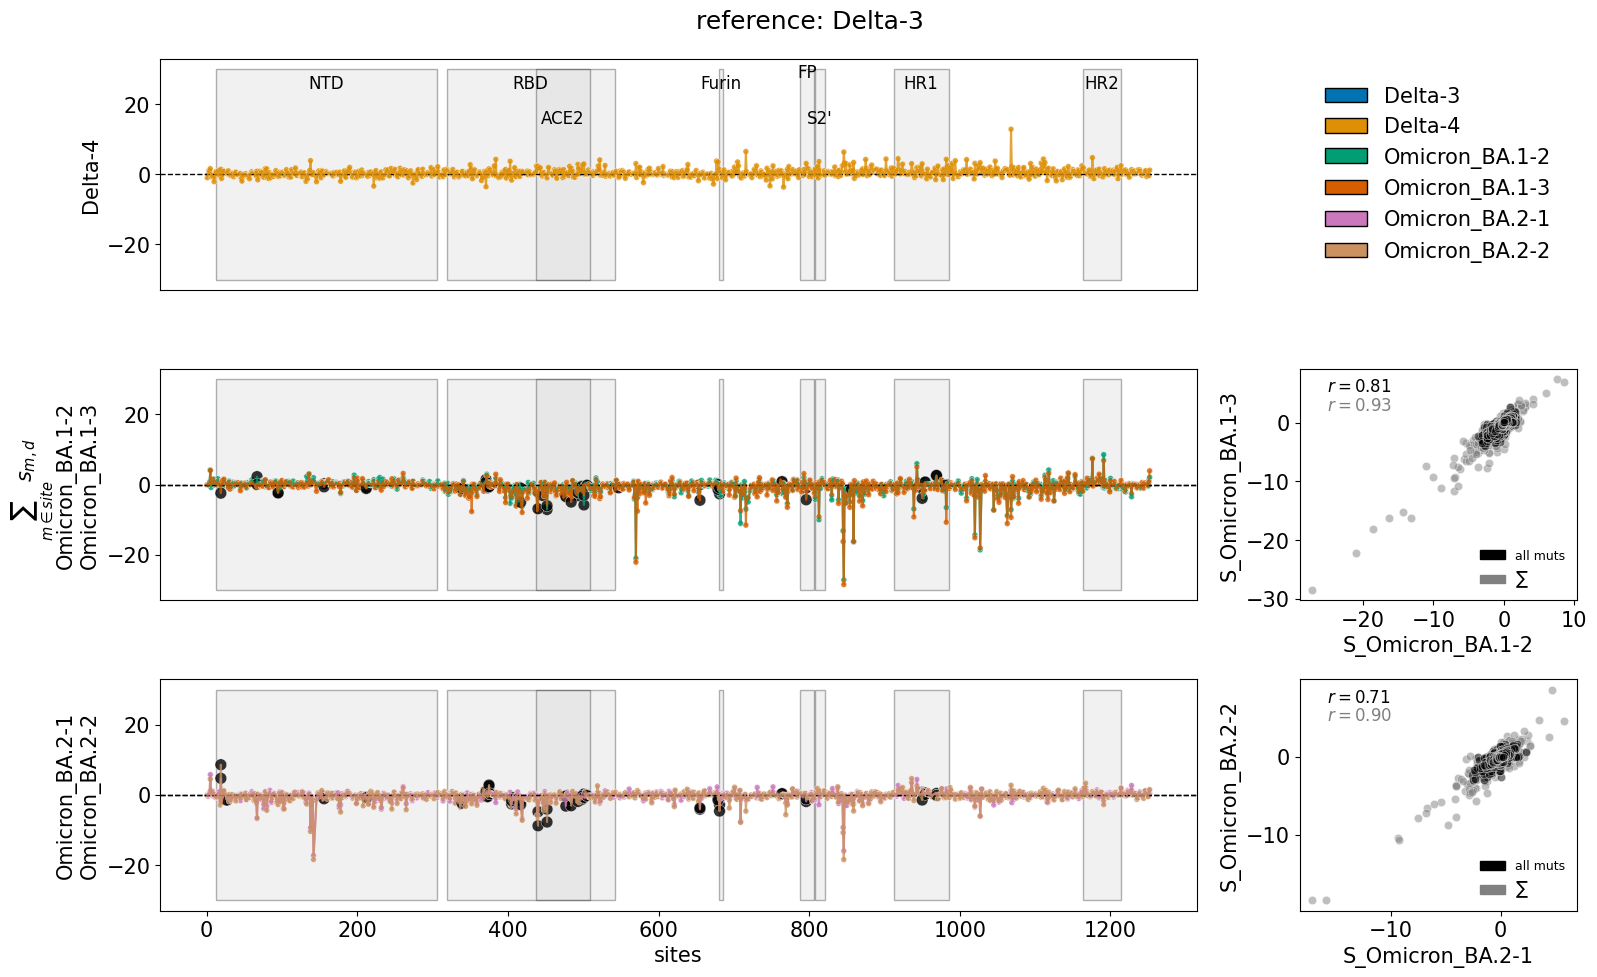

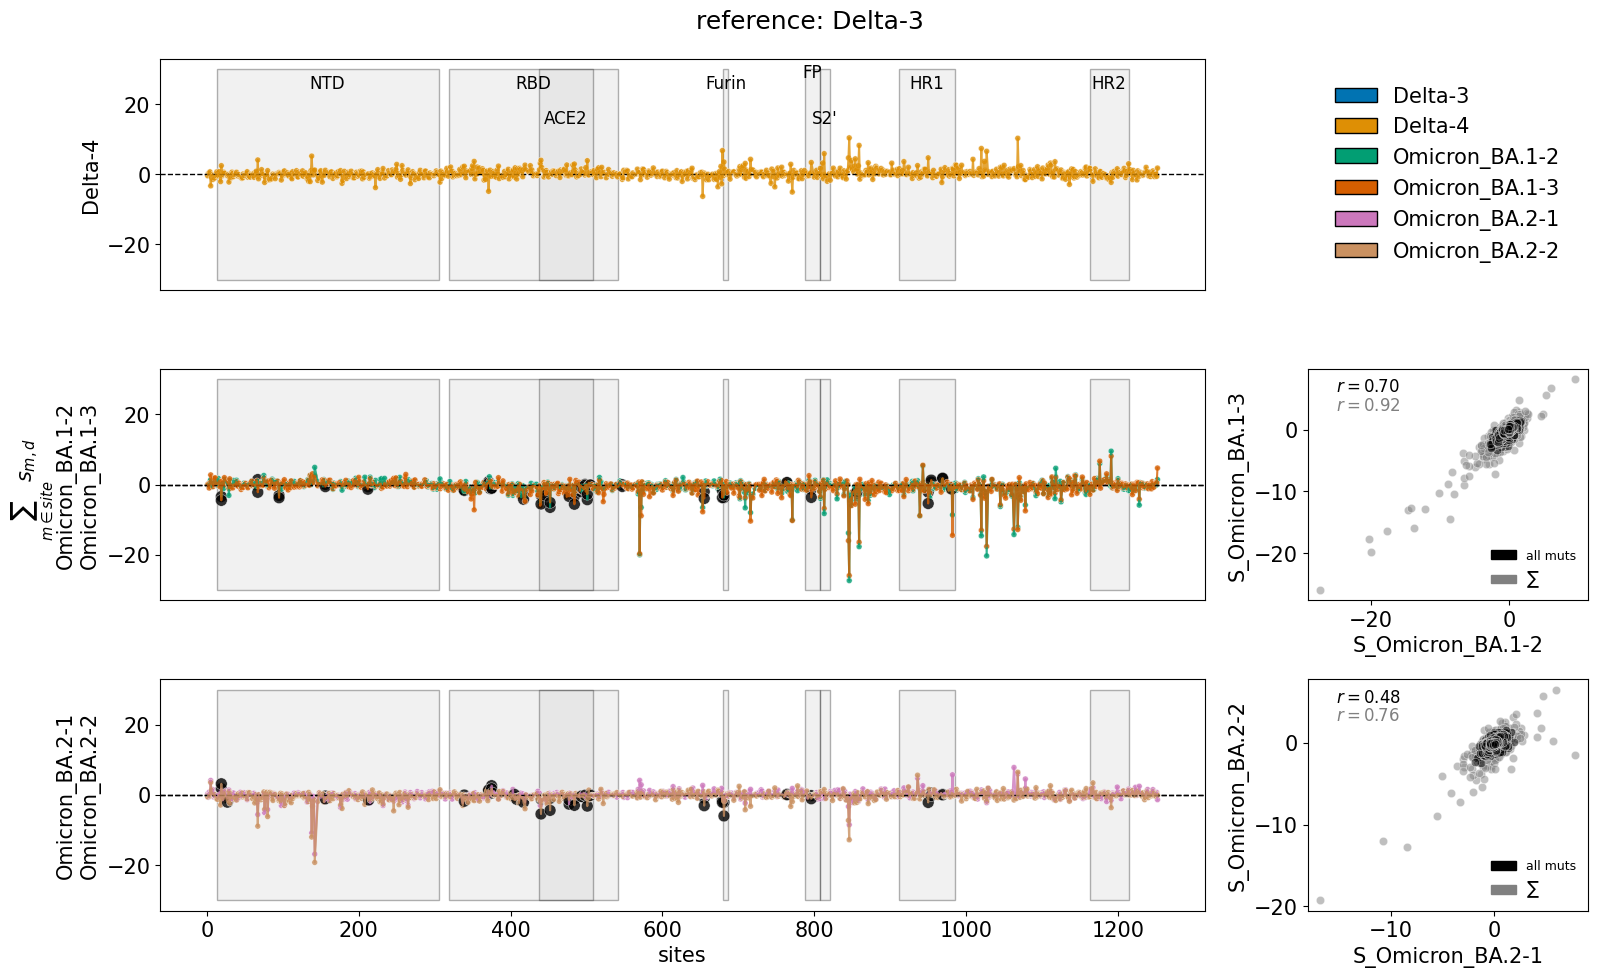

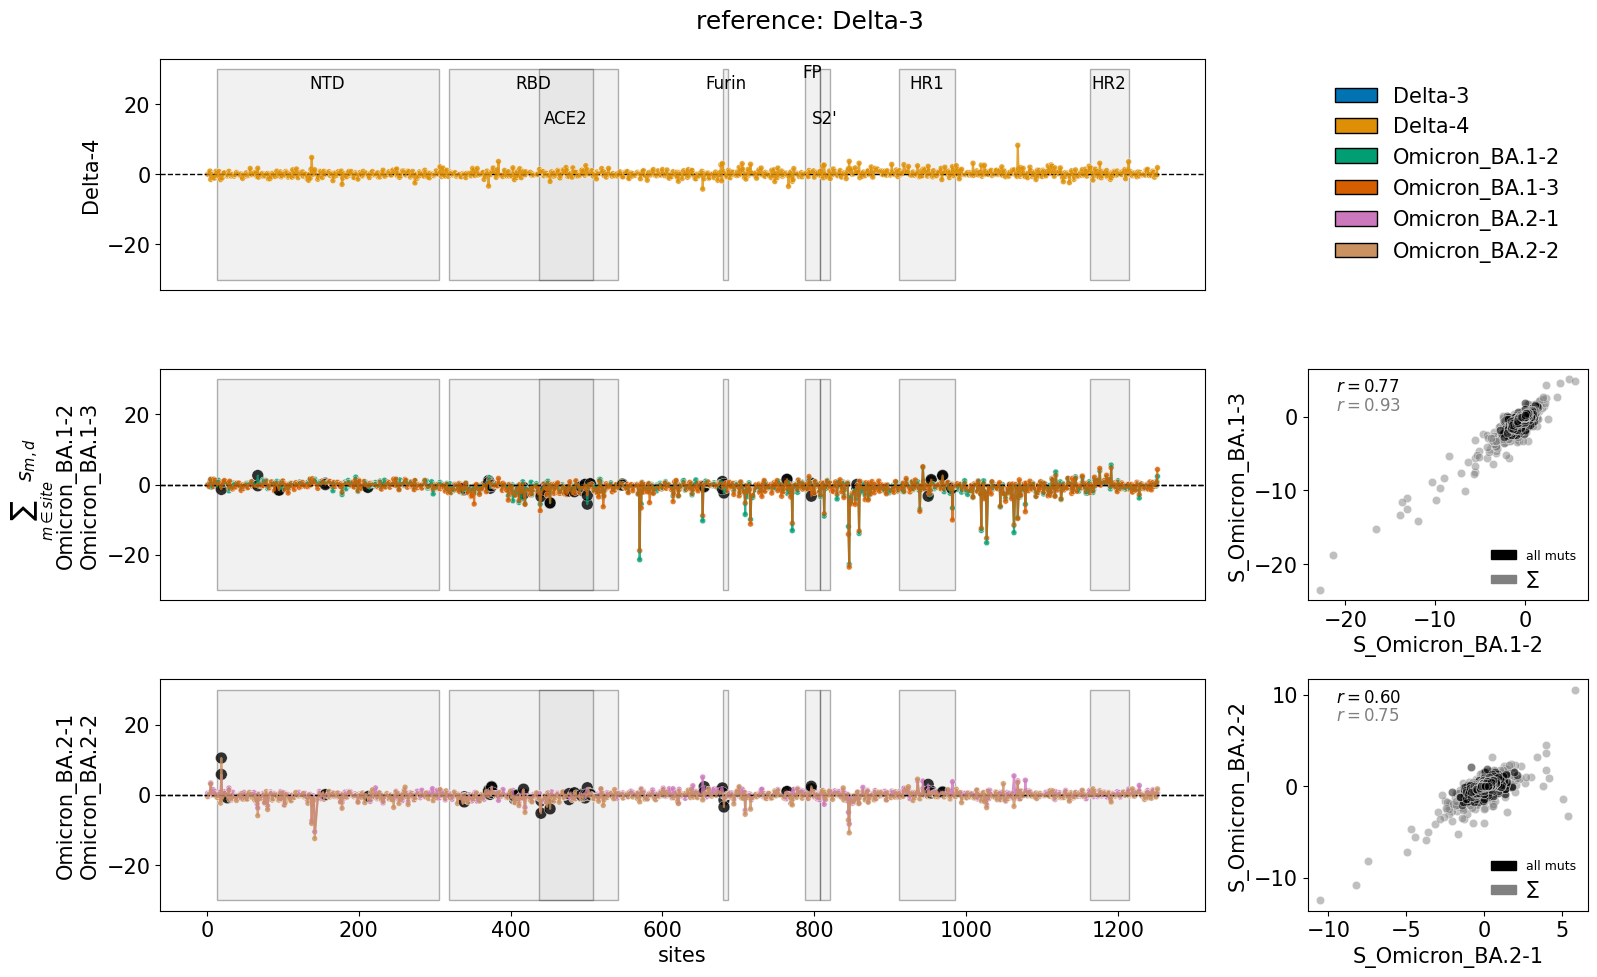

In [63]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 15})

#         aceX
for model in [0, 1, 2]:
    fig = plt.figure(constrained_layout=True, figsize=(16,10))
    axd = fig.subplot_mosaic(
        """
        bbbg
        dddh
        fffi
        """,
        empty_sentinel="X",
        gridspec_kw={
#         "bottom": 0.25,
#         "top": 0.95,
#         "left": 0.1,
#         "right": 0.5,
#         "wspace": 0.5,
#         "hspace": 0.2,
#         "wspace": 0.2  
        }
    )

    protein_regions = {
        "NTD" :  [13, 305],                                                 
        "RBD" : [319, 541],
        "ACE2" : [437, 508],
        "Furin" : [680, 685],
        "FP" : [788, 806],
        "S2'"  : [808, 820],
        "HR1" : [912, 984],
        "HR2" : [1163, 1213]
    }
    
    

    moi = models_df.loc[model, "model"]
    fig.suptitle(f"reference: {moi.data.reference}")
#     fig.suptitle(f"Reference: {moi.data.reference}\n")
#     moi.plot_epistasis(show=False, legend=False, alpha=0.05, ax=axd["c"])
#     moi.plot_pred_accuracy(show=False, legend=False, alpha=0.05, ax=axd["e"], annotate_corr=False)

    facet_groups = {
        ("b", "g") : ("Delta-3", "Delta-4"),
        ("d", "h") : ("Omicron_BA.1-2", "Omicron_BA.1-3"),
        ("f", "i") : ("Omicron_BA.2-1", "Omicron_BA.2-2")
    }

    for axi, facet_group in facet_groups.items():

        for pr, data in protein_regions.items():

            start = data[0]
            end = data[1] + 1
            width = end - start
            middle = start + (width//2)

            rect_v = patches.Rectangle(
                    (start, -30),
                    width=width,
                    height=60,
                    clip_on=False,
                    linewidth=1,
                    edgecolor='black',
                    facecolor='lightgrey',
                    alpha=0.3
            )
            axd[axi[0]].add_patch(rect_v)

        condition_ylabel = []
        for condition in facet_group:
            
            if condition == moi.data.reference: continue
            
            condition_ylabel.append(condition)
            moi.plot_shifts_by_site(
                condition,
                show=False, 
                agg_func=onp.sum,
                times_seen_threshold=3,
                ax=axd[axi[0]],
                alpha=0.8
            )
            
        ylabel =  '\n' + '\n'.join(condition_ylabel)
#         if axi[0] == "d":
#             ylabel = "$\sum_{m \in site}s_{m,d}$\n" + ylabel
        axd[axi[0]].set_ylabel(ylabel)
        
        if moi.data.reference not in facet_group:
            
            from scipy.stats import pearsonr
            
            mut_df = moi.mutation_site_summary_df(agg_func=onp.sum, times_seen_threshold=3)
#             mut_df = moi.mutations_df
            
            times_seen_cols = [c for c in mut_df.columns if "times" in c]
            for c in times_seen_cols:
                mut_df = mut_df[mut_df[c]>=3]
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="grey"
                
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.82),
                xycoords="axes fraction", fontsize=12, color="grey"
            )
            
            legend_elements = [
                patches.Patch(
                     facecolor="black", 
                     edgecolor="black", 
                     label="all muts"
                ),
                patches.Patch(
                    facecolor="grey", 
                    edgecolor="grey", 
                    label="$\sum$" #_{m \in site}s_{m,d}$"
                )
                
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="lower right",
                    frameon=False,
                    fontsize=9
            )
            
            mut_df = moi.mutations_df
            
            times_seen_cols = [c for c in mut_df.columns if "times" in c]
            for c in times_seen_cols:
                mut_df = mut_df[mut_df[c]>=3]
                
            x = mut_df[f"S_{facet_group[0]}"].values
            y = mut_df[f"S_{facet_group[1]}"].values
            r = pearsonr(x, y)[0]
            sns.scatterplot(mut_df,
                x=f"S_{facet_group[0]}",
                y=f"S_{facet_group[1]}", 
                ax=axd[axi[1]],
                alpha=0.5,
                color="black"
            )
            axd[axi[1]].annotate(
                f"$r = {r:.2f}$", (0.1, 0.9),
                xycoords="axes fraction", fontsize=12, color="black"
            )
        
                 
        else:
            
            axd[axi[1]].axis('off')
            legend_elements = [
                patches.Patch(
                     facecolor=col, 
                     edgecolor="black", 
                     label=con
                )
                for con, col in cc.items()
            ]
            axd[axi[1]].legend(
                    handles=legend_elements, 
                    loc="center",
                    frameon=False
            )
            
    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        anno = f"{pr}" #": \n{start}-{end}"
        ycoord = 26
        if pr in ["ACE2", "S2'"]:
            ycoord = 16
        if pr in ["FP"]:
            ycoord = 29

        axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=12, rotation=0)

    axd["b"].get_xaxis().set_visible(False)
    axd["d"].get_xaxis().set_visible(False)
    

    fig.text(0.00, 0.5, "$\sum_{m \in site}s_{m,d}$", va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f"shifts_reference_{moi.data.reference}.png")

In [ ]:
# import pickle
# moi = models_df.loc[0, "model"]
# pickle.dump(moi, open("delta-6c-sigmoid.pkl", "wb"))

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(constrained_layout=True, figsize=(14,8))
axd = fig.subplot_mosaic(
    """
    abcg
    defX
    """,
    empty_sentinel="X",
#     sharex=True,
#     sharey=True,
    width_ratios=[2, 2, 2, 1],
)

# which fits go where
model_ax_dict = {
    "a" : 0,
    "b" : 1,
    "c" : 2,
    "d" : 0,
    "e" : 1,
    "f" : 2
}

for axi, model in model_ax_dict.items():
    moi = models_df.loc[model, "model"]
    if axi in ["a", "b", "c"]:
        moi.plot_epistasis(show=False, legend=False, alpha=0.15, ax=axd[axi])
    else:
        moi.plot_pred_accuracy(show=False, legend=False, alpha=0.15, ax=axd[axi])
    
    epi = "Sigmoid"
    if axi in ["b", "e"]:
        epi = "Softplus"
    if axi in ["c", "f"]:
        epi = "Identity"
        
    axd[axi].set_title(epi)

axd["b"].set_ylabel("")
axd["e"].set_ylabel("")
axd["c"].set_ylabel("")
axd["f"].set_ylabel("")

axd["a"].set_xlabel("")
axd["d"].set_xlabel("")
axd["c"].set_xlabel("")
axd["f"].set_xlabel("")

axd["g"].axis('off')
legend_elements = [
    patches.Patch(
         facecolor=col, 
         edgecolor="black", 
         label=con
    )
    for con, col in cc.items()
]
axd["g"].legend(
        handles=legend_elements, 
        loc="center",
        frameon=False
)
plt.tight_layout()
fig.savefig("epi-model-compare.png")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 13})

from functools import reduce
mutations_dfs = []
for model, ge_func in zip([0,1,2], ["sigmoid", "softplus", "identity"]):
    mut_df = models_df.loc[model, "model"].mutations_df.set_index("mutation")
    
    new_column_name_map = {c:f"{c}_{ge_func}" for c in mut_df.columns}
    mut_df = mut_df.rename(new_column_name_map, axis=1)
    times_seen_cols = [c for c in mut_df.columns if "times" in c]
    for c in times_seen_cols:
        mut_df = mut_df[mut_df[c] >= 3]
    mutations_dfs.append(mut_df)
    

df_merged = reduce(
    lambda  left,right: pd.merge(
        left,
        right,
        left_index=True, 
        right_index=True,
        how='outer'
    ), 
    mutations_dfs
)
df_merged.head()

df_merged = df_merged.assign(is_stop = [True if "*" in mut else False for mut in df_merged.index])

In [ ]:
df_merged.head()

In [ ]:
# fig, ax = plt.subplots(figsize=[9, 9])
shifts_map = {
    c:c.split("_")[-1] 
    for c in df_merged.columns 
    if "S_Omicron_BA.1-2" in c
}
g = sns.pairplot(
    data = df_merged.rename(shifts_map, axis=1), 
    vars=shifts_map.values(), 
#     hue="is_stop", 
    diag_kind="kde", 
    corner=True,
    height=3
#     ax=ax
)
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g.map_lower(corrfunc)

g.savefig("shift-correlation.png")
plt.show()